In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from tabulate import tabulate

E:\Ana\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ana\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\Ana\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Load the VIX data
vix_data = pd.read_csv('vix_data.csv', parse_dates=['Date'], index_col='Date')

start_date = '1990-01-02'
end_date = '2023-02-28'

# Create a DatetimeIndex with business day frequency
date_index = pd.bdate_range(start=start_date, end=end_date)

# Create a DataFrame with the date index
df = pd.DataFrame(index=date_index)

# Add your VIX data to the DataFrame
df['VIX'] = vix_data

In [3]:
# Train-test split
train_data = df[:-365*4] # use all data except last year for training
test_data = df[-365*4:] # use last year for testing

test_data = test_data.fillna(method = 'bfill')

In [4]:
# Hyperparameter tuning using AIC
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
aic_values = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_data, order=(p, d, q))
                results = model.fit()
                aic_values.append((p, d, q, results.aic))
            except:
                continue
# Get the order with the smallest AIC
p, d, q, _ = sorted(aic_values, key=lambda x: x[3])[0]
print(f"ARIMA({p}, {d}, {q}) has the smallest AIC value of {_}")

E:\Ana\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Ana\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) has the smallest AIC value of 25281.686545252818


In [5]:
# Train the ARIMA model
model = ARIMA(train_data, order=(p, d, q))
results = model.fit()

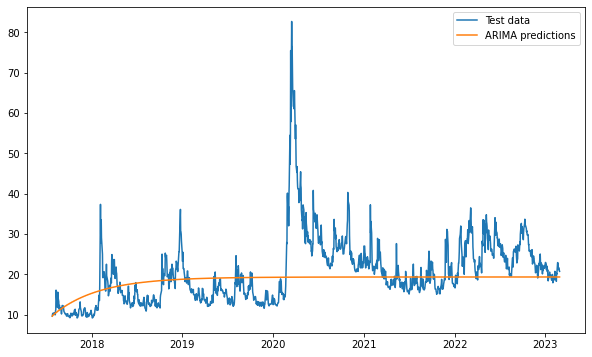

In [11]:
# Make predictions on the test data
pred = results.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

# Plot predicted values vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Test data')
plt.plot(pred, label='ARIMA predictions')
plt.legend()
plt.show()

In [12]:
# Compute performance metrics
rmse = mean_squared_error(test_data, pred, squared=False)
mae = mean_absolute_error(test_data, pred)
r2 = r2_score(test_data, pred)
medae = median_absolute_error(test_data, pred)

In [13]:
# Create table with performance metrics
table = [
    ['RMSE', f'{rmse:.4f}'],
    ['MAE', f'{mae:.4f}'],
    ['R^2', f'{r2:.4f}'],
    ['Median absolute error', f'{medae:.4f}'],
]

# Print table
print(tabulate(table, headers=['Metric', 'Value'], tablefmt='grid'))

+-----------------------+---------+
| Metric                |   Value |
+=======================+=========+
| RMSE                  |  8.122  |
+-----------------------+---------+
| MAE                   |  5.3619 |
+-----------------------+---------+
| R^2                   |  0.0728 |
+-----------------------+---------+
| Median absolute error |  3.9423 |
+-----------------------+---------+


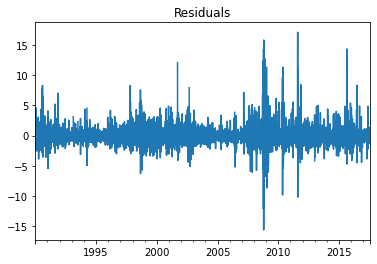

There are missing values in the residuals.
There are no missing values in the residuals.


In [14]:
# Diagnostic Test
# Plot the residuals
residuals = results.resid
residuals.plot()
plt.title('Residuals')
plt.show()

if np.isnan(residuals).any():
    residuals = results.resid.fillna(method='ffill')
    print('There are missing values in the residuals.')
else:
    print('There are no missing values in the residuals.')
    
if np.isnan(residuals).any():
    print('There are missing values in the residuals.')
else:
    print('There are no missing values in the residuals.')

E:\Ana\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


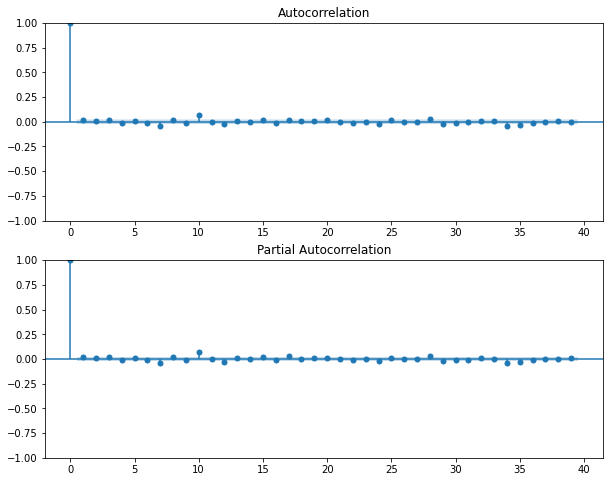

Ljung-Box Q statistic: lb_stat
P-value: lb_pvalue


In [15]:
# Plot the autocorrelation and partial autocorrelation of the residuals
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_acf(residuals, ax=ax[0])
plot_pacf(residuals, ax=ax[1])
plt.show()

# Perform the Ljung-Box test for autocorrelation of the residuals
lbvalue, pvalue = acorr_ljungbox(residuals, lags=10)
print('Ljung-Box Q statistic:', lbvalue)
print('P-value:', pvalue)